In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import shutil

In [ ]:
!unzip /content/drive/MyDrive/Datasets/OCT2017_dataset.zip

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
target_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/OCT2017/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        '/content/OCT2017/val',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


# ResNet50

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
feature_extractor = ResNet50(weights='imagenet',
                          input_shape=(224, 224, 3),
                          include_top=False)
feature_extractor.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

unfreezing 6 layer

In [ ]:
for layer in feature_extractor.layers[0 :-20]:
    layer.trainable = False

feature_extractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
inp_layer = Input(shape = (224, 224, 3))
features = feature_extractor(inp_layer)

flat = Flatten()(features)
FC1 = Dense(units = 300, activation = 'relu')(flat)
FC2 = Dense(units = 200, activation = 'relu')(FC1)
output = Dense(units = 4, activation = 'softmax')(FC2)

model = Model(inputs = inp_layer, outputs = output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 300)               30105900  
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 4)                 804       
                                                                 
Total params: 53,754,616
Trainable params: 39,098,232
Non-tra

In [ ]:
opt = Adam(learning_rate = 0.0001)
model.compile(optimizer = opt, loss=categorical_crossentropy, metrics = 'acc')

In [ ]:
results= model.fit(train_generator,
                    epochs = 10,
                    validation_data=validation_generator)

Epoch 1/10
5218/5218 [==============================] - 513s 95ms/step - loss: 0.7387 - acc: 0.7249 - val_loss: 3.1245 - val_acc: 0.3750
Epoch 2/10
5218/5218 [==============================] - 475s 91ms/step - loss: 0.5874 - acc: 0.7824 - val_loss: 0.8215 - val_acc: 0.6562
Epoch 3/10
5218/5218 [==============================] - 440s 84ms/step - loss: 0.5270 - acc: 0.8063 - val_loss: 0.2562 - val_acc: 0.9375
Epoch 4/10
5218/5218 [==============================] - 436s 83ms/step - loss: 0.4927 - acc: 0.8175 - val_loss: 0.2606 - val_acc: 0.8438
Epoch 5/10
5218/5218 [==============================] - 433s 83ms/step - loss: 0.4570 - acc: 0.8322 - val_loss: 0.5505 - val_acc: 0.7812
Epoch 6/10
5218/5218 [==============================] - 427s 82ms/step - loss: 0.4316 - acc: 0.8433 - val_loss: 0.9725 - val_acc: 0.6562
Epoch 7/10
5218/5218 [==============================] - 422s 81ms/step - loss: 0.4116 - acc: 0.8502 - val_loss: 0.2698 - val_acc: 0.9375
Epoch 8/10
5218/5218 [===================

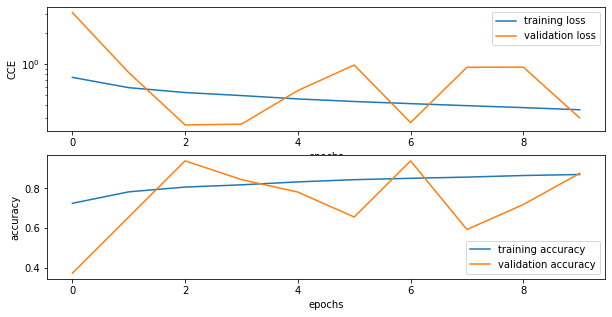

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [ ]:
y_pred_test_Res = model.predict(test_generator)

In [ ]:
thresh = 0.5
y_pred_test_Res[y_pred_test_Res >= thresh] = 1
y_pred_test_Res[y_pred_test_Res < thresh]  = 0

In [ ]:
y_pred_test_Res=np.argmax(y_pred_test_Res,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_test_Res))

[[195  17  30   0]
 [  5 235   2   0]
 [  3   5 234   0]
 [  8  75   1 158]]


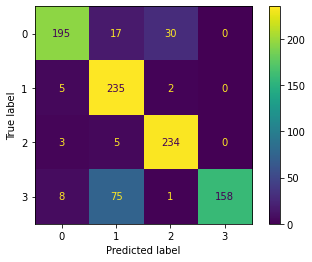

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred_test_Res)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(test_generator.classes, y_pred_test_Res)

print(cls_report)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       242
           1       0.71      0.97      0.82       242
           2       0.88      0.97      0.92       242
           3       1.00      0.65      0.79       242

    accuracy                           0.85       968
   macro avg       0.88      0.85      0.85       968
weighted avg       0.88      0.85      0.85       968



saving model

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = results.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/Models/2-5/ResNet50_6.json', 'w'))

In [ ]:
!mkdir -p saved_model
model.save('/content/drive/MyDrive/Models/2-5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/2-5/assets


# InceptionV3(6 layer)

In [ ]:

from tensorflow.keras.applications.inception_v3  import InceptionV3
from tensorflow.keras.applications.inception_v3  import preprocess_input
from tensorflow.keras.layers import Input
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
target_size = (299, 299)

train_datagen2 = ImageDataGenerator(rescale=1./255)
val_datagen2 = ImageDataGenerator(rescale=1./255)

train_generator2 = train_datagen2.flow_from_directory(
        '/content/OCT2017/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator2 = val_datagen2.flow_from_directory(
        '/content/OCT2017/val',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [ ]:

feature_extractor_Incept= InceptionV3(weights='imagenet',
                          input_shape=(299, 299, 3),
                          include_top=False)
feature_extractor_Incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 149, 149, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

unfreezing 6 layer

In [ ]:

for layer in feature_extractor_Incept.layers[0 :-22]:
    layer.trainable = False

feature_extractor_Incept.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 149, 149, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In [ ]:

inp_layer = Input(shape = (299, 299, 3))
features2 = feature_extractor_Incept(inp_layer)

flat = Flatten()(features2)
FC1 = Dense(units = 300, activation = 'relu')(flat)
FC2 = Dense(units = 200, activation = 'relu')(FC1)
output = Dense(units = 4, activation = 'softmax')(FC2)

model2 = Model(inputs = inp_layer, outputs = output)

model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 300)               39321900  
                                                                 
 dense_4 (Dense)             (None, 200)               60200     
                                                                 
 dense_5 (Dense)             (None, 4)                 804       
                                                                 
Total params: 61,185,688
Trainable params: 42,203,000
Non-t

In [ ]:

opt = Adam(learning_rate = 0.0001)
model2.compile(optimizer = opt, loss=categorical_crossentropy, metrics = 'acc')

results_InceptionV3 = model2.fit(train_generator2,
                    epochs = 10,
                    validation_data=validation_generator2)

Epoch 1/10
5218/5218 [==============================] - 548s 104ms/step - loss: 0.3235 - acc: 0.8870 - val_loss: 0.0481 - val_acc: 1.0000
Epoch 2/10
5218/5218 [==============================] - 519s 99ms/step - loss: 0.1829 - acc: 0.9361 - val_loss: 0.1038 - val_acc: 0.9688
Epoch 3/10
5218/5218 [==============================] - 514s 98ms/step - loss: 0.1206 - acc: 0.9583 - val_loss: 0.0282 - val_acc: 1.0000
Epoch 4/10
5218/5218 [==============================] - 513s 98ms/step - loss: 0.0794 - acc: 0.9724 - val_loss: 0.0336 - val_acc: 1.0000
Epoch 5/10
5218/5218 [==============================] - 503s 96ms/step - loss: 0.0556 - acc: 0.9808 - val_loss: 0.0496 - val_acc: 0.9688
Epoch 6/10
5218/5218 [==============================] - 507s 97ms/step - loss: 0.0440 - acc: 0.9845 - val_loss: 0.0264 - val_acc: 0.9688
Epoch 7/10
5218/5218 [==============================] - 505s 97ms/step - loss: 0.0366 - acc: 0.9872 - val_loss: 0.0743 - val_acc: 0.9375
Epoch 8/10
5218/5218 [==================

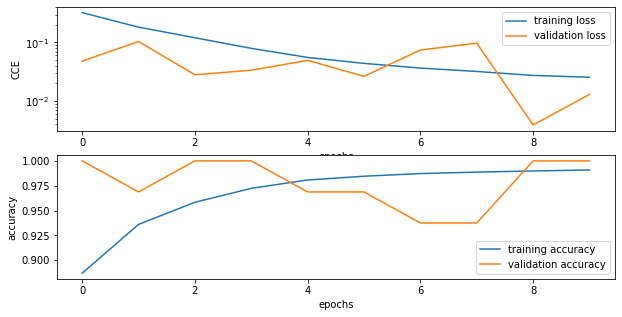

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results_InceptionV3.history['loss']
val_loss = results_InceptionV3.history['val_loss']
train_acc = results_InceptionV3.history['acc']
val_acc = results_InceptionV3.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [ ]:
y_pred_test_Incept = model2.predict(test_generator)

In [ ]:
y_pred_test_Incept=np.argmax(y_pred_test_Incept,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_test_Incept))

[[242   0   0   0]
 [  2 238   0   2]
 [  4   0 238   0]
 [  0   0   0 242]]


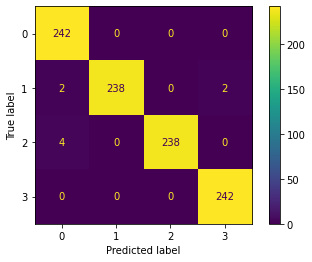

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred_test_Incept)

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(test_generator.classes, y_pred_test_Incept)

print(cls_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       242
           1       1.00      0.98      0.99       242
           2       1.00      0.98      0.99       242
           3       0.99      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = results_InceptionV3.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/Models/2-5(Incept)/InceptionV3_6.json', 'w'))

In [ ]:
!mkdir -p saved_model
model.save('/content/drive/MyDrive/Models/2-5(Incept)')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/2-5(Incept)/assets
